In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, microwave_coupling_matrix, \
                                        generate_laser_D, generate_microwave_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations

In [2]:
script_dir = Path().parent.absolute().parent
script_dir

WindowsPath('C:/Users/Olivier/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Js_g = [0,1] # J values to be included

parity = lambda J: (-1)**J

# generate a list of approximate ground states

I_F = 1/2
I_Tl = 1/2

#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

In [4]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [5]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [6]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [7]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [1/2]
F_excited = [0]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

In [8]:
for s in excited_states_approx:
    s.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [9]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [10]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [11]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [12]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [13]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
# excited_states_laser_approx = [1*CoupledBasisState(
#                                 F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
#                                 )
#                             ]
excited_states_laser_approx = excited_states_approx

In [14]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = +1, Omega = 1)

In [15]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [16]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0
H_laser_z_1[np.abs(H_laser_z_1) < 1e-6] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-6] = 0

In [17]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([1,0,0])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.3529061368774218+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [18]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

## Microwave coupling

In [19]:
# Define ground states for microwaves
Js = [1]
ground_states_microwave1_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

# Define excited states for microwaves
Je = [0]
excited_states_microwave1_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Je
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

In [20]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_μ1_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0)
excited_μ1_main_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**0, Omega = 0)

In [21]:
ground_states_μ1 = find_exact_states(
                                ground_states_microwave1_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_μ1 = find_exact_states(
                                excited_states_microwave1_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_μ1_z = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ1, 
                                    excited_states = excited_states_μ1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_μ1_y = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ1, 
                                    excited_states = excited_states_μ1, 
                                    pol_vec = np.array([0,1,0]), 
                                    reduced = False
                                    )

In [22]:
# set small values to zero
H_μ1_z[np.abs(H_μ1_z) < 1e-3*np.max(np.abs(H_μ1_z))] = 0
H_μ1_y[np.abs(H_μ1_y) < 1e-3*np.max(np.abs(H_μ1_y))] = 0

In [23]:
ground_μ1_main = find_exact_states([ground_μ1_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_μ1_main = find_exact_states([excited_μ1_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_μ1_main = ED_ME_mixed_state(
                        ground_μ1_main, excited_μ1_main, pol_vec = np.array([0,0,1])
                        )

ground_μ1_main_idx = QN.index(ground_μ1_main)
excited_μ1_main_idx = QN.index(excited_μ1_main)

print(ME_μ1_main)
ground_μ1_main_approx.print_state()
print('-'*100)
ground_μ1_main.print_state()
print('='*100)
excited_μ1_main_approx.print_state()
print('-'*100)
excited_μ1_main.print_state()

(-0.35290852811303564+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [24]:
D_μ1 = generate_microwave_D(H_rot, QN, ground_μ1_main, excited_μ1_main, excited_states_μ1, Δ = 0)

## Generate Symbolic Hamiltonian

In [25]:
def generate_coupling(ham, coupling_matrix, Ω, ω):
    entries = list(zip(*np.nonzero(coupling_matrix)))[:len(np.nonzero(coupling_matrix)[0])//2]
    for id1, id2 in entries:
        ham.addCoupling(id1,id2,-1*coupling_matrix[id1,id2]*2*Ω, ω)
        
def generate_detuning(ham, coupling_matrix, δ):
    entries = list(zip(*np.nonzero(coupling_matrix)))[:len(np.nonzero(coupling_matrix)[0])//2]
    for id1, id2 in entries:
        ham.defineStateDetuning(id1,id2,δ)

In [26]:
from sympy import nsimplify

ham = Hamiltonian(len(H_int))

energies = []
for idx, energy in enumerate(np.diag(H_int)):
    E = Symbol(f"E{idx}", real = True)
    energies.append((E, energy))

ham.addEnergies(list(zip(*energies))[0])

generate_coupling(ham, H_laser_z_1, Symbol('Ωl', real = True)*Symbol('Plz', real = True)/ME_main_1/2, Symbol('ωl', real = True))
generate_coupling(ham, H_laser_x_1, Symbol('Ωl', real = True)*Symbol('Plx', real = True)/ME_main_1/2, Symbol('ωl', real = True))

generate_coupling(ham, H_μ1_z, Symbol('Ωμ', real = True)*Symbol('Pμz', real = True)/ME_μ1_main/2, Symbol('ωμ', real = True))
generate_coupling(ham, H_μ1_y, Symbol('Ωμ', real = True)*Symbol('Pμy', real = True)/ME_μ1_main/2, Symbol('ωμ', real = True))
ham.eqnTransform()

generate_detuning(ham, H_laser_z_1, Symbol('δl', real = True))
generate_detuning(ham, H_laser_x_1, Symbol('δl', real = True))
generate_detuning(ham, H_μ1_z, Symbol('δμ', real = True))
generate_detuning(ham, H_μ1_y, Symbol('δμ', real = True))


ham.defineZero(energies[-1][0])

# ham.transformed = nsimplify(ham.transformed)
ham.transformed

ham_transformed = ham.transformed.subs(energies)
ham_transformed

Matrix([
[           -1.0*δl - 1.0*δμ,                                   0,                                   0,                                   0,                           0, 0.290807911472161*I*Pμy*Ωμ,    0.411234074581972*Pμz*Ωμ,  0.290764892751861*I*Pμy*Ωμ, -0.499983382824011*I*Pμy*Ωμ,   -0.707100975358803*Pμz*Ωμ, -0.500008409156251*I*Pμy*Ωμ,                           0,                           0,                           0,                           0,                           0,                         0],
[                          0, -1.0*δl - 1.0*δμ - 83545.9813906599,                                   0,                                   0, -0.333901922157883*I*Pμy*Ωμ,   -0.49999180136918*Pμz*Ωμ, -0.353586231008722*I*Pμy*Ωμ,                           0,   -0.290736980011639*Pμz*Ωμ, -0.205594736946309*I*Pμy*Ωμ,                           0, -0.578405249432978*I*Pμy*Ωμ,   -0.578433636785611*Pμz*Ωμ, -0.236156135505686*I*Pμy*Ωμ,                           0,                 

In [27]:
# ham.energies = list(ham.energies)
# indices = []
# for row_idx in range(ham.levels):
#     row = ham.hamiltonian[row_idx,:]
#     if len(np.nonzero(row)[0]) == 1:
#         indices.append(row_idx)
        
# cnt = 0
# for idx in indices:
#     del ham.energies[idx-cnt]
#     ham.hamiltonian.row_del(idx-cnt)
#     ham.hamiltonian.col_del(idx-cnt)
#     ham.couplings.row_del(idx-cnt)
#     ham.couplings.col_del(idx-cnt)
#     ham.rabi.row_del(idx-cnt)
#     ham.rabi.col_del(idx-cnt)
#     ham.cpl = np.delete(ham.cpl, idx-cnt, 0)
#     cnt += 1
    
# ham.levels = len(ham.cpl)

# ham.hamiltonian

In [28]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.23it/s]


In [29]:
ρ = MatrixSymbol('ρ', ham.levels,ham.levels)

matrix_mult_sum = zeros(*ρ.shape)
for C,Cᶜ in zip(C_array, C_conj_array):
    idC = np.nonzero(C)
    idCᶜ = np.nonzero(Cᶜ)
    val = C[idC][0]*Cᶜ[idCᶜ][0]*ρ[idC[-1][0],idCᶜ[0][0]]
    matrix_mult_sum[idC[0][0],idCᶜ[-1][0]] += val   
    
Cprecalc = np.einsum('ijk,ikl', C_conj_array, C_array)
a = -0.5 * (Cprecalc@ρ + ρ@Cprecalc)

dissipator = matrix_mult_sum + a
dissipator

Matrix([
[                         0,                          0,                          0,                          0,                          0,                          0,                          0,                          0,                          0,                          0,                           0,                           0,                           0,                           0,                           0,                           0,  -5026548.21497941*ρ[0, 16]],
[                         0,                          0,                          0,                          0,                          0,                          0,                          0,                          0,                          0,                          0,                           0,                           0,                           0,                           0,                           0,                           0,  -5026548.21497941*ρ[1, 16]],
[                    

## Julia

In [30]:
# import julia
# julia.install()

In [31]:
from julia import Main

In [32]:
nprocs = 6 # number of processes to use for EnsembleDistributed
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
end
""")

    
Main.eval("procs()")

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [33]:
polarizations = 'Plx Plz Pμy Pμz'.split(' ')

In [34]:
from sympy import MutableDenseMatrix, conjugate, Function, Symbol, Matrix

t = Symbol('t', real = True)

hamiltonian_symbols = ham_transformed.free_symbols
dissipator_symbols = dissipator.free_symbols
dissipator_symbols = set([d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']])

lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
#     print(s, polarizations, str(s) in polarizations)
    if str(s) not in polarizations:
        Main.eval(f"""
                    @everywhere @parameters {str(s)}
                    tmp = 0
                """);
    else:
        Main.eval(f"@everywhere @variables {str(s)}(t)")


diss = str(MutableDenseMatrix(dissipator.copy()))

# for i in range(lx):
#     for j in range(i,ly):
#         tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
#                                          chr(0x2080+j)))
#         tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
#         diss = diss.subs(conjugate(tmp(t)), tmp1(t))

ρ = MatrixSymbol('ρ', ham.levels+1,ham.levels+1)
for i in range(lx):
    for j in range(i,ly):
        tmp = f'ρ[{i}, {j}]'
        tmp1 = f'ρ[{i+1}, {j+1}]'
        diss = diss.replace(tmp, tmp1)
        tmp = f'ρ[{j}, {i}]'
        tmp1 = f'ρ[{j+1}, {i+1}]'
        diss = diss.replace(tmp, tmp1)
diss = eval(diss)


H_real, H_imag = ham_transformed.as_real_imag()
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval_re = str(H_real[idx-1,idy-1])
        hval_im = str(H_imag[idx-1,idy-1])
        if hval_im != '0':
            hval_im = 'icomplex*' + hval_im
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
#         print(f'{hval_re} + {hval_im}')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval_re} + {hval_im}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);

ρ = MatrixSymbol('ρ', ham.levels,ham.levels)

In [35]:
Main.eval("""
@everywhere @variables Plz(t) Pl(t) Pμ(t) Nl(t) Nμ(t)
@everywhere @parameters ωlp ωμp ϕl ϕμ Ωl Ωμ δl δμ
tmp = 0;
""");

In [36]:
ham_string = ','.join([str(h) for h in hamiltonian_symbols])
diss_string = ','.join([str(d) for d in dissipator_symbols])

Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    append!(eqns, [Pl ~ sin(ωlp*t+ϕl)])
    append!(eqns, [Pμ ~ sin(ωμp*t+ϕμ)])
    append!(eqns, [Pμy ~ (1+Pl)/2])
    append!(eqns, [Pμz ~ (1-Pl)/2])
    append!(eqns, [Plx ~ (1+Pμ)/2])
    append!(eqns, [Plz ~ (1-Pμ)/2])
    bloch = ODESystem(eqns)
    tmp = 0
end
""");

In [48]:
Main.eval("@everywhere bloch = structural_simplify(bloch)");

In [38]:
system = generate_system_of_equations(ham_transformed, C_array, progress = True)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.44it/s]


In [39]:
code_lines = system_of_equations_to_lines(system)

In [52]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tνpl = p[2]
\t\tδl = p[3]
\t\tϕl = p[4]
\t\tΩμ = p[5]
\t\tνpμ = p[6]
\t\tδμ = p[7]
\t\tϕμ = p[8]

\t\tPl = sin(2π*νpl*t + ϕl)
\t\tPlx = (1+Pl)/2
\t\tPlz = (1-Pl)/2

\t\tPμ = sin(2π*νpμ*t + ϕμ)
\t\tPμy = (1+Pμ)/2
\t\tPμz = (1-Pμ)/2
"""

In [53]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [54]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

### Generate density matrix

In [43]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [44]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [45]:
T = 6.3
ρ_ini = np.zeros(H_rot.shape, dtype = 'complex')

for J in range(0,2):
    p = population(J, T)
    levels = J_levels(J)
    sl = J_slice(J)
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)

ρ_ini /= np.diag(ρ_ini).sum()
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [46]:
Γ = 2*np.pi * 1.56e6


Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    p1 = [Γ, 1e6, 0, 0, Γ, 1e6, 0, π/2]
end
""")

In [59]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p1, 0.)
tmp = 0
""")

Wall time: 5.92 s


0

In [60]:
Main.eval("parameters(bloch)")

[<PyCall.jlwrap icomplex>,
 <PyCall.jlwrap Ωμ>,
 <PyCall.jlwrap δl>,
 <PyCall.jlwrap δμ>,
 <PyCall.jlwrap Ωl>,
 <PyCall.jlwrap ωlp>,
 <PyCall.jlwrap ϕl>,
 <PyCall.jlwrap ϕμ>,
 <PyCall.jlwrap ωμp>]

In [61]:
Main.eval("""
    @everywhere begin
    p = [
    Ωl => Γ,
    Ωμ => Γ,
    δl => 0,
    δμ => 0,
    ϕl => π/2,
    ϕμ => π,
    ωlp => 2π*1e6,
    ωμp => 2π*1e6,
    icomplex => im
    ]
    dim = size(ρ_ini)[1]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:dim for idy in 1:dim]
end
""");

In [62]:
Main.eval("""
@everywhere begin
    tspan = (0.0, 300e-6)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

In [63]:
Main.eval("@everywhere p1 = [Γ, 1e6, 0, π/2, Γ, 1e6, 0, π]")

In [64]:
Main.eval("@everywhere prob1 = ODEProblem(Lindblad_rhs!, ρ_ini, tspan, p1)")

In [68]:
Main.eval("@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false)");

In [69]:
Main.eval("@time sol1 = solve(prob1, Tsit5(), abstol = 1e-9, reltol = 1e-6, progress = false)");

In [70]:
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t") 

2.962067114205269

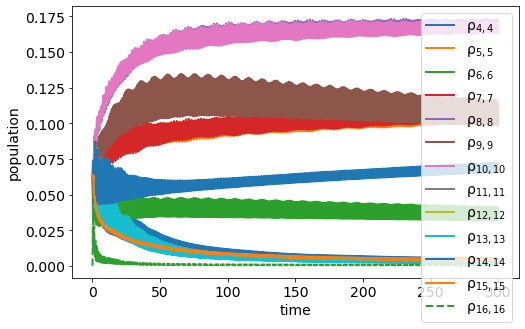

In [71]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '--' if idx in [16] else '-'
    if idx not in [0,1,2,3]:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
#         ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
        ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1]].real, axis = 0), t_array)*Main.Γ

In [72]:
ut = np.array(Main.eval("sol1[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol1.t")

2.9610733276671684

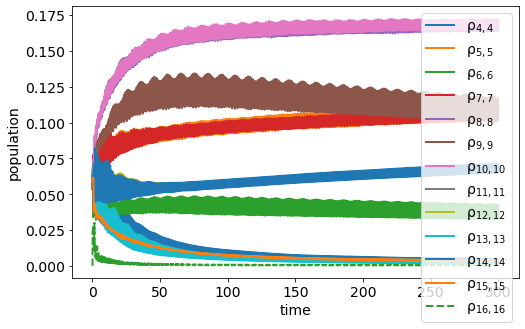

In [73]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '--' if idx in [16] else '-'
    if idx not in [0,1,2,3]:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
#         ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
        ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

np.trapz(np.sum(pop_results[[-1]].real, axis = 0), t_array)*Main.Γ

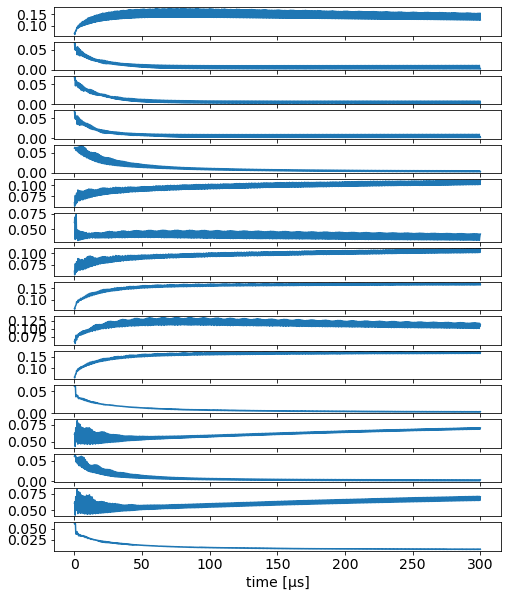

In [74]:
fig, axes = plt.subplots(figsize = (8,10), nrows = len(pop_results)-1, sharex = True)
for idx, pop in enumerate(pop_results[:-1]):
    axes[idx].plot(t_array*1e6, pop)

axes[idx].set_xlabel('time [μs]')
for ax in axes:
    set_fontsize(ax, 14)

### Parameter scan for polarization switching frequency

In [ ]:
Main.eval("""
@everywhere params = [val*Γ for val in 0:5/401:5]""")

In [ ]:
Main.eval("""
@everywhere function output_func(sol,i)
           return trapz(sol.t, [real(sol.u[j][end]) for j in 1:size(sol.u)[1]]), false
       end
""")

In [ ]:
# this function remakes the problem to change the parameters
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    pnew = ModelingToolkit.varmap_to_vars([
    Ωl => Γ,
    Ωμ => Γ,
    δl => 0,
    δμ => 0,
    ϕl => 0,
    ϕμ => π/2,
    ωlp => params[i],
    ωμp => params[i],
    icomplex => im
    ], parameters(bloch))
   remake(prob, p = pnew)
end
""")

In [ ]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [ ]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), Main.eval("sim.u")*Γ, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('photons per molecule')
set_fontsize(ax, 14)